# Application of Kernel Methods to PCA, SVM and KNN

## loading basic libraries

In [8]:
import warnings #prevent "future warning" errors
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
from time import time
import datetime
%matplotlib inline

Credit: The theory presented here was adapted from Princeton's ELE 535. 

## Kernel-PCA on synthetic data

## Notes on the synthetic data

Data contains 1000 points, the first 500 of which belongs to class #1 and the rest belongs to class #2. Each row corresponds to one data point.

## Loading data

In [22]:
#loading data
data = np.load("data_PCA.npy")
print("total data shape: ", data.shape)

#separating into classes
data1 = data[:500,:]
data2 = data[500:,:]

#printing properties
print("data 1 shape: ", data1.shape)
print("data 2 shape: ", data2.shape)

total data shape:  (1000, 3)
data 1 shape:  (500, 3)
data 2 shape:  (500, 3)


## Visualizing the data in 3D

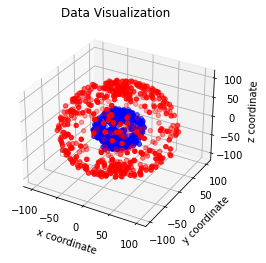

In [23]:
#plotting data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data1[:,0], data1[:,1], data1[:,2], c='r')
ax.scatter(data2[:,0], data2[:,1], data2[:,2], c='b') #, marker='x')

ax.set_title('Data Visualization')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
plt.show()


## Applying standard PCA and projecting into first 2 principal components 

Shape PCA Data: (1000, 2)


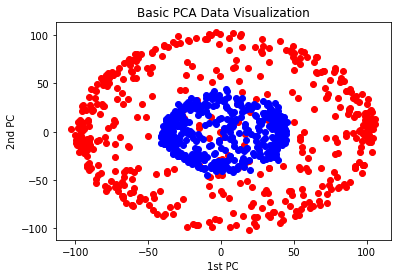

Estimated running time:0:00:00.160195


In [24]:
from sklearn.decomposition import PCA
start = time()

#performing PCA
pca = PCA(n_components=2)
dataPCA = pca.fit_transform(data)
print("Shape PCA Data:", dataPCA.shape)

#plotting into first 2 principal components
plt.figure()
plt.scatter(dataPCA[:500,0], dataPCA[:500,1], c='r')
plt.scatter(dataPCA[500:,0], dataPCA[500:,1], c='b')

plt.title('Basic PCA Data Visualization')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

## Performing kernel PCA with a 4th order inhomogeneous polynomial kernel

size of Gramm Matrix:  (1000, 1000)
Shape of Principal Compenets:  (1000, 2)


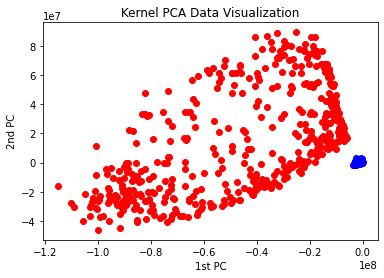

Estimated running time:0:00:00.420930


In [9]:
start = time()

#adapted some code from https://sebastianraschka.com/Articles/2014_kernel_pca.html

#number of principal components
pComponents = 2

#centering data
mean = data.mean()
cData = data - mean

#finding Gramm Matrix of centered data: 1000 by 3
#the inhomogenious 4th order polinomial is (1 + X^tX)^4
K1 = (1+ cData @ cData.T)**4
print("size of Gramm Matrix: ",K1.shape,)

#finding eigenvectors of the kernelized gramm matrix (1+ (covariance matrix) ^4)
eVal, eVec = eigh(K1)

#finding Principal Components
PrincipalComponents = np.column_stack((eVec[:,-i]*(eVal[-i]**0.5) for i in range(1,pComponents+1)))
print("Shape of Principal Compenets: ",PrincipalComponents.shape)

#plotting
plt.figure()
plt.scatter(PrincipalComponents[:500,0], PrincipalComponents[:500,1], c='r')
plt.scatter(PrincipalComponents[500:,0], PrincipalComponents[500:,1], c='b')

plt.title('Kernel PCA Data Visualization')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

## Implementing kernel PCA with the RBF gaussian kernel and different gammas

kernel: $(k(x,z) = e^{-\gamma \lVert {x-z} \lVert_2^2}, \gamma = 1/2\sigma^2)$.

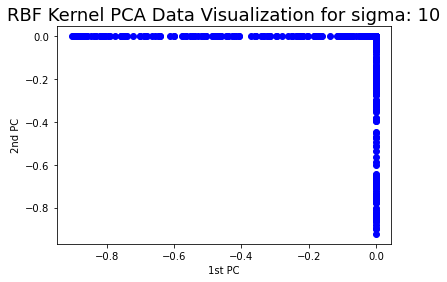

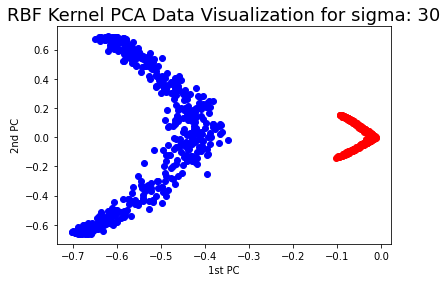

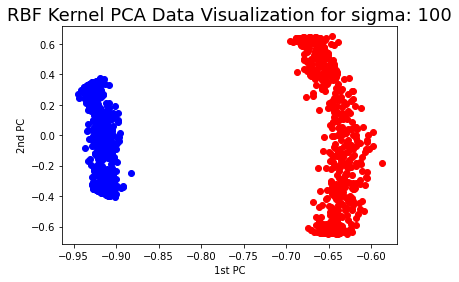

Estimated running time:0:00:01.185848


In [10]:
start = time()

#Adapted some code from
#https://stats.stackexchange.com/questions/15798/how-to-calculate-a-gaussian-kernel-effectively-in-numpy

#centering data
mean = data.mean()
cData = data - mean

#rbf kernel PCA function
def rbfPCA(n_Componets, Sigma, cData):
    
    #finding Gramm Matrix of centered data: 1000 by 3
    gamma = 1/(2*Sigma**2)
    distances = squareform(pdist(cData, 'sqeuclidean'))
    K = np.exp(-gamma*distances)

    #finding eigenvectors
    eVal, eVec = eigh(K)

    #finding Principal Components
    PrincipalComponents = np.column_stack((eVec[:,-i]*(eVal[-i]**0.5) for i in range(1,pComponents+1)))
    
    return PrincipalComponents

#plotting
sigmaList = [10,30,100]
for sigma in sigmaList:

    PC = rbfPCA(2,sigma,cData)
    
    plt.figure()
    plt.scatter(PC[:500,0], PC[:500,1], c='r')
    plt.scatter(PC[500:,0], PC[500:,1], c='b')

    plt.title('RBF Kernel PCA Data Visualization for sigma: ' + str(sigma),fontsize=18)
    plt.xlabel('1st PC')
    plt.ylabel('2nd PC')
    plt.show()

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

# Kernel-SVM on MNIST Written Digits

## Notes on MINST dataset 

The MNIST dataset is a collection of 28 x 28 grayscale 2D images of handwritten digits. You can find more information on http://yann.lecun.com/exdb/mnist/.


## Importing a subset of MNIST dataset

In [12]:
#setting training and testing data
train_data = np.load('MNISTcwtrain1000.npy') #can be found in MNST website (too big to include in github)
train_data = train_data.astype(dtype='float64')
test_data = np.load('MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

#normalizing data
train_data = train_data/255.0
test_data = test_data/255.0


## Looking at mean handwritten digits for fun

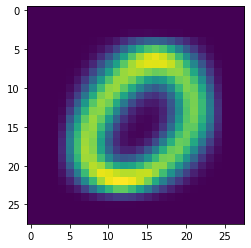

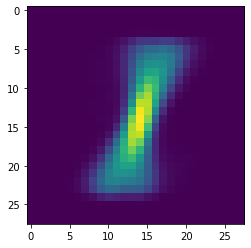

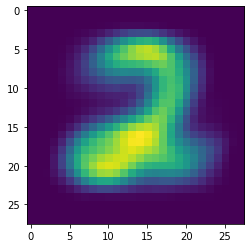

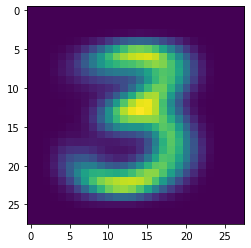

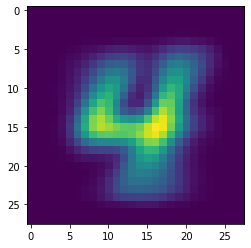

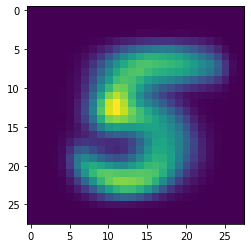

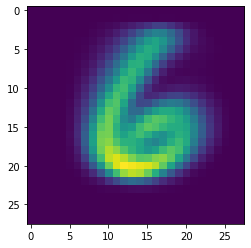

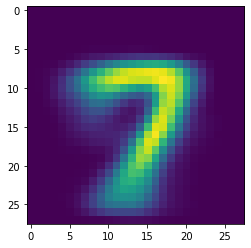

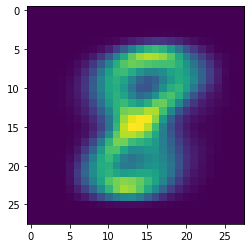

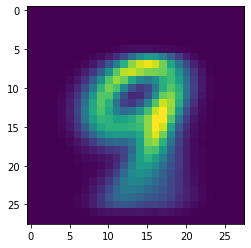

<Figure size 432x288 with 0 Axes>

In [17]:
#obtaining mean vector
meanVector = np.zeros((784,10))
for i in range(1,11):
    rowAvgTrain = np.mean(train_data[:,((i-1)*1000):(i*1000)], axis=1)
    meanVector[:,i-1] = rowAvgTrain
    
# Function that converts a 1D vectorized image into a (nr x nc) 2D array
def unpackcw(x,nr,nc): 
    A = x.reshape(nc,nr)
    return A.T

#show figure function
def showFigure(num,meanVector):
    im = unpackcw(meanVector[:,num],28,28)
    plt.imshow(im)
    plt.figure()
    
#plotting figures
for i in range(0,10):
    showFigure(i,meanVector)

## Classification data using linear SVM kernel


In [13]:
from sklearn import svm

start = time()

#setting labels
labels = range(0,10)
train_labels = np.repeat(labels,1000)
test_labels = np.repeat(labels,100)

# linear kernel fitting
kernel='linear'
clf = svm.SVC(kernel=kernel)
clf.fit(train_data.T, train_labels)
pred_test_labels = clf.predict(test_data.T)
Acc =1- (np.mean(np.count_nonzero(test_labels-pred_test_labels))/1000)
print("Accuracy with a linear kernel :::: "+str(Acc))

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

Accuracy with a linear kernel :::: 0.911
Estimated running time:0:00:08.659289


## Using a RBF gaussian kernel on SVM for different values of gamma

In [14]:
start = time()

n_features = train_data.shape[0]
gamma1 = 1/(n_features * train_data.T.var())

kernel='rbf'
clf = svm.SVC(kernel=kernel, gamma = gamma1)
clf.fit(train_data.T, train_labels)
pred_test_labels = clf.predict(test_data.T)
Acc =1- (np.mean(np.count_nonzero(test_labels-pred_test_labels))/1000)
print("gamma ::: "+str(round(gamma1,5)))
print("Accuracy :::: "+str(Acc))

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

gamma ::: 0.01331
Accuracy :::: 0.947
Estimated running time:0:00:15.967207


In [103]:
start = time()

gamma2 = 1/(n_features)

kernel='rbf'
clf = svm.SVC(kernel=kernel, gamma = gamma2)
clf.fit(train_data.T, train_labels)
pred_test_labels = clf.predict(test_data.T)
Acc =1- (np.mean(np.count_nonzero(test_labels-pred_test_labels))/1000)
print("gamma ::: "+ str(round(gamma2,5)))
print("Accuracy :::: "+str(Acc))

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

gamma ::: 0.00128
Accuracy :::: 0.896
Estimated running time:0:00:35.120224


In [104]:
start = time()

gamma3 = 10*gamma1 

kernel='rbf'
clf = svm.SVC(kernel=kernel, gamma = gamma3)
clf.fit(train_data.T, train_labels)
pred_test_labels = clf.predict(test_data.T)
Acc =1- (np.mean(np.count_nonzero(test_labels-pred_test_labels))/1000)
print("gamma ::: "+str(round(gamma3,5)))
print("Accuracy :::: "+str(Acc))

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

gamma ::: 0.13307
Accuracy :::: 0.7150000000000001
Estimated running time:0:02:30.521235


Note that The Value of gamma can significantly change the accuracy of the predictions. We found that scaling gamma by the number of samples AND the variance of the data is better than just scaling by the number of samples. Also, values of gamma that are too large or too small compared to the correct scaling can negatively affect the accuracy of the predicitons.

# Kernel KNN Classifier on Liver Disorders Data Set

## Notes on liver disorder data

The data in this section is obtained from the BUPA Liver Disorder database from BUPA Medical Research Ltd. (http://archive.ics.uci.edu/ml/datasets/Liver+Disorders). It contains data from 345 male individuals.

The first 5 features are results from blood tests. They are sensitive to liver disorders that may arise from excessive alcohol consumption. The sixth feature is the number of drinks per day. The last column specifies whether someone has the disorder or not.

## Loading Data

In [18]:
#loading data
data = np.loadtxt("Liver_Dataset.txt")
train_data = data[0:245,:6]
train_labels = data[0:245,6]
test_data = data[245:,0:6]
test_labels = data[245:,6]

## Implemeting basic KNN Classifier

In [109]:
from sklearn.neighbors import KNeighborsClassifier
start = time()

model = KNeighborsClassifier(n_neighbors=1)
model.fit(train_data,train_labels)
pred = model.predict(test_data)
acc = model.score(test_data,test_labels)
print("Testing Accuracy: ",acc)

end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))

Testing Accuracy:  0.61
Estimated running time:0:00:00.010481


## Implementing 3-th order inhomogeneous polynomial kernel on KNN


In [20]:
start = time()

#This is a two part procces:
    #1) Make function that identifies label of nearest neighborn
    #2) Create the actual classifier function

# 1) make function that identifies the label of the nearest neighbor 
def getLabel(trainData,testSample,K): 
    
    nTrainSamples = trainData.shape[1]
    
    ##initializing array that has "kernel distances" and labels
    distanceAndLabelArray = np.zeros((nTrainSamples,2))
    distanceAndLabelArray[:,0] = train_labels #adding labels
    
    #calculating the kernel objective function "kernel distance"
    for i in range(nTrainSamples):
        #sample kernel calculation
        k = (1+trainData[:,i] @ testSample)**3 
        
        #adding value of objective function to the array
        distanceAndLabelArray[i,1] = -(2*k-K[i,i]) 
        
    #sorting distances and the labels
    distanceAndLabelArray = distanceAndLabelArray[distanceAndLabelArray[:,1].argsort()] 
    
    #choosing best label based on closest distance
    bestLabel = distanceAndLabelArray[0,0]
    return bestLabel
   
# 2) Coding the classifier
def kernelKNN(trainData, testData):
    nTestSamples = testData.shape[1]
    resultLabels = np.zeros((1,nTestSamples))
    
    #calculating Gramm Matrix
    K = (1+ data @ data.T)**3

    #get label of nearest neighbor
    for j in range(nTestSamples):
        resultLabels[:,j] =  getLabel(trainData,testData[:,j],K) 
        
    #calculating accuracy    
    accuracy = np.sum( test_labels == resultLabels) / nTestSamples
    return resultLabels, accuracy
        
labels, accuracy = kernelKNN(train_data.T, test_data.T)

print("\nThe accuracy of the kernelized KNN model is", accuracy, "this is about 2% better than the standard classifier \n")
    
end = time()
print('Estimated running time:' + str(datetime.timedelta(seconds=end - start)))



The accuracy of the kernelized KNN model is 0.63 this is about 2% better than the standard classifier 

Estimated running time:0:00:00.113688
